In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

path_to_abca7 = '/home/gridsan/djuna/homer/github/ABCA7lof2'
import sys
sys.path.append(path_to_abca7)

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

In [2]:
frame = pd.read_csv('../supplementary_tables/data_s8.csv')

unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

/state/partition1/slurm_tmp/24642792.0.0/ipykernel_1553075/3859499087.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


In [8]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0)]

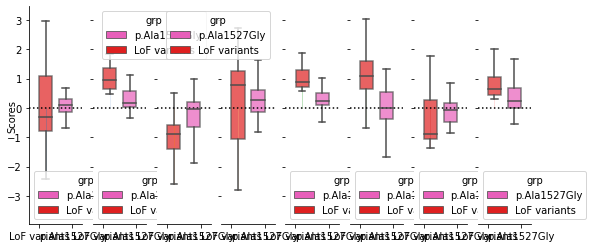

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

<Figure size 180x360 with 0 Axes>

In [33]:
######## show common vs rare variant cluster perturbation patterns

scores = pd.read_csv('../processed_data/common_var/rs3752246_binary_scores.csv', index_col = 0)
scores['description'] = scores.index
temp = pd.merge(scores, frame, on = 'description')
temp['grp'] = 'p.Ala1527Gly'

# scores = pd.read_csv('../processed_data/common_var/ex_scoresE4.csv', index_col = 0)
# scores['description'] = scores.index
# temp1 = pd.merge(scores, frame, on = 'description')
# temp1['grp'] = 'E4'

scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
scores = pd.DataFrame(scores['Ex'])
scores = scores.rename(columns={"Ex": "scores"})
scores['description'] = scores.index
temp2 = pd.merge(scores, frame, on = 'description')
temp2['grp'] = 'LoF variants'
TEMP = pd.concat((temp, temp2), axis=0)

fig, axes = plt.subplots(1,8, sharey=True, figsize=(9,4))
grp_colors = {
    'LoF variants': (1.0, 0.0, 0.0, 1.0),
    'p.Ala1527Gly': (1.0, 0.2824, 0.7608, 1.0)
}

for i in np.unique(TEMP['cluster']):
    plt.figure(figsize = (2.5,5))
    temp = TEMP[TEMP['cluster']==i]
    #temp['scores'] = np.abs(temp['scores'])
    boxplot = sns.boxplot(data = temp, x = 'grp', y='scores',hue='grp',palette=grp_colors, ax=axes[i], boxprops=dict(alpha=.7),flierprops=dict( marker='.', markersize=0 ), order=['LoF variants','p.Ala1527Gly'], orient='v')
    
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    
    if i>0:
        axes[i].spines[['left']].set_visible(False)

    #axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    #axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axhline(0, color='black', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    #axes[i].set_yticklabels([])

#     if i==7:
#         continue
#     axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right') 


     # Rotate x-axis labels

# Add common title for the y-axis
fig.text(0.1, 0.5, 'Scores', ha='center', va='center', rotation='vertical')

fig.savefig('../pdf_figures/common_var_clusters.pdf')

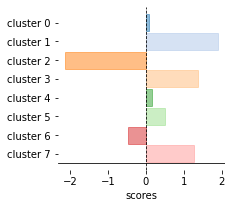

In [146]:
# barplot
temp = pd.read_csv('../processed_data/common_var/rs3755246_cluster_effects.csv')

temp['score'] = np.sign(temp['NES']) * -np.log10(temp['pval'])
temp['cluster'] = ['cluster ' + str(x) for x in temp['pathway']]

plt.figure(figsize=(3,3))
index = np.argsort(-1*temp['pathway'])
temp = temp.loc[index]
#sns.barplot(data=temp, y='cluster', x='score', palette=colors, orient='h', order=temp['cluster'][np.argsort(temp['pathway'])], height=.2)
plt.barh(y=temp['cluster'], width=temp['score'], color=colors[::-1], height=.9, alpha=.5, edgecolor=colors[::-1])
plt.box(False)
plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line',  linewidth=0.8)
plt.axhline(y=-0.5, color='black', linewidth=0.8)
plt.xlabel('scores')
plt.savefig('../pdf_figures/common_var_bar.pdf')

In [147]:
temp

,Unnamed: 0,pathway,pval,padj,log2err,ES,NES,size,score,cluster
3,4,7,0.053047,0.106093,0.076608,0.455928,1.408364,40,1.275342,cluster 7
5,6,6,0.338596,0.451462,0.036511,-0.387688,-1.085840,18,-0.470318,cluster 6
4,5,5,0.312539,0.451462,0.028688,0.358629,1.099306,38,0.505096,cluster 5
6,7,4,0.668592,0.764105,0.017485,0.323588,0.862752,20,0.174839,cluster 4
2,3,3,0.040667,0.106093,0.087357,0.456386,1.430772,43,1.390763,cluster 3
0,1,2,0.007539,0.050774,0.274717,-0.521591,-1.666116,31,-2.122684,cluster 2
1,2,1,0.012693,0.050774,0.159153,0.517189,1.585338,38,1.896419,cluster 1
7,8,0,0.835604,0.835604,0.013323,0.250252,0.767096,38,0.078000,cluster 0
